# **Advance Topics in Machine Learning**
## **Assignment 0 - Introduction**
---

### **Task 4: Training Variational Autoencoders**

In [1]:
# Cell 1: Setup — imports, device, seeds, folders
# If needed: !pip -q install torchvision matplotlib numpy
import os, random, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Reproducibility
seed = 42
random.seed(seed); np.random.seed(seed)
torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

os.makedirs("vae_outputs", exist_ok=True)


Device: cuda


In [2]:
# Cell 2: Data — FashionMNIST loaders (normalize to [-1, 1])
BATCH_SIZE = 128

tf = transforms.Compose([
    transforms.ToTensor(),                     # [0,1]
    transforms.Normalize((0.5,), (0.5,)),     # -> [-1,1]
])

train_full = datasets.FashionMNIST(root="./data", train=True, download=True, transform=tf)
test_set   = datasets.FashionMNIST(root="./data", train=False, download=True, transform=tf)

# Make a small validation split from train_full (e.g., 55k train / 5k val)
val_size = 5000
train_size = len(train_full) - val_size
train_set, val_set = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(seed))

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, drop_last=True)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=False)

len(train_set), len(val_set), len(test_set)


100%|██████████| 26.4M/26.4M [00:21<00:00, 1.25MB/s]


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 181kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:07<00:00, 566kB/s] 


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 326kB/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



(55000, 5000, 10000)

In [3]:
# Cell 3: Model — import provided architecture.py (assumed present in working dir)
# The architecture is expected to define a class VAE with:
# forward(x) -> recon, mu, logvar
# encode(x) -> mu, logvar
# reparameterize(mu, logvar) -> z
# decode(z) -> recon
try:
    import architecture as arch
    VAE = arch.VAE
    print("Loaded architecture.VAE from architecture.py")
except Exception as e:
    raise RuntimeError(
        "Could not import architecture.py. Please place the provided file in the working directory.\n"
        f"Original error: {e}"
    )

# Instantiate model
vae = VAE().to(device)
print(vae.__class__.__name__, "on", device)


Loaded architecture.VAE from architecture.py
VAE on cuda


In [4]:
# Cell 4: Loss — reconstruction (MSE) + KL divergence; utilities
def mse_recon_loss(recon, x):
    # both in [-1,1]; assume x is normalized; average per-batch
    return F.mse_loss(recon, x, reduction="mean")

def kl_divergence(mu, logvar):
    # KL(q(z|x) || p(z)) where p is N(0, I):
    # 0.5 * sum( exp(logvar) + mu^2 - 1 - logvar ) averaged over batch
    # Use mean over batch and dimensions
    return 0.5 * torch.mean(torch.exp(logvar) + mu**2 - 1.0 - logvar)

@torch.no_grad()
def evaluate_epoch(model, loader, beta=1.0):
    model.eval()
    recon_sum, kl_sum, n_batches = 0.0, 0.0, 0
    for x, _ in loader:
        x = x.to(device)
        recon, mu, logvar = model(x)
        recon_loss = mse_recon_loss(recon, x)
        kl = kl_divergence(mu, logvar)
        recon_sum += recon_loss.item()
        kl_sum += kl.item()
        n_batches += 1
    return {
        "recon": recon_sum / n_batches,
        "kl": kl_sum / n_batches,
        "total": (recon_sum / n_batches) + beta * (kl_sum / n_batches),
    }


In [5]:
# Cell 5: Training loop (baseline) — fixed beta=1.0
def train_vae(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=1e-3,
    beta=1.0,            # constant beta
    tag="baseline",
    log_interval=100,
    out_dir="vae_outputs",
):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    hist = {"train_recon": [], "train_kl": [], "train_total": [],
            "val_recon": [],   "val_kl":   [], "val_total": []}

    step = 0
    for ep in range(1, epochs+1):
        model.train()
        recon_running, kl_running, nb = 0.0, 0.0, 0
        for x, _ in train_loader:
            x = x.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(x)
            recon_loss = mse_recon_loss(recon, x)
            kl = kl_divergence(mu, logvar)
            loss = recon_loss + beta * kl
            loss.backward()
            opt.step()

            recon_running += recon_loss.item()
            kl_running += kl.item()
            nb += 1

            if step % log_interval == 0:
                print(f"[{tag}] Epoch {ep:02d} Step {step:05d} | recon {recon_loss.item():.4f} | kl {kl.item():.4f} | total {loss.item():.4f}")
            step += 1

        # epoch means
        train_recon = recon_running / nb
        train_kl    = kl_running / nb
        train_total = train_recon + beta * train_kl

        # validation
        val_metrics = evaluate_epoch(model, val_loader, beta=beta)

        hist["train_recon"].append(train_recon)
        hist["train_kl"].append(train_kl)
        hist["train_total"].append(train_total)
        hist["val_recon"].append(val_metrics["recon"])
        hist["val_kl"].append(val_metrics["kl"])
        hist["val_total"].append(val_metrics["total"])

        # save checkpoint & a small reconstruction grid each epoch
        torch.save(model.state_dict(), os.path.join(out_dir, f"vae_{tag}_epoch_{ep:03d}.pt"))

        with torch.no_grad():
            x_vis, _ = next(iter(val_loader))
            x_vis = x_vis.to(device)[:16]
            recon_vis, _, _ = model(x_vis)
            grid = vutils.make_grid(torch.cat([(x_vis+1)/2, (recon_vis+1)/2], dim=0), nrow=16, pad_value=1.0)
            vutils.save_image(grid, os.path.join(out_dir, f"recon_{tag}_epoch_{ep:03d}.png"))

        print(f"[{tag}] Epoch {ep:02d} train(total={train_total:.4f}, recon={train_recon:.4f}, kl={train_kl:.4f}) "
              f"| val(total={val_metrics['total']:.4f}, recon={val_metrics['recon']:.4f}, kl={val_metrics['kl']:.4f})")

    return hist


In [6]:
# Cell 6: Run baseline training (Task 4.1)
baseline_hist = train_vae(
    vae, train_loader, val_loader,
    epochs=20,
    lr=1e-3,
    beta=1.0,           # standard ELBO
    tag="baseline",
    log_interval=100,
    out_dir="vae_outputs",
)


[baseline] Epoch 01 Step 00000 | recon 1.3887 | kl 0.0015 | total 1.3902
[baseline] Epoch 01 Step 00100 | recon 0.6456 | kl 0.0000 | total 0.6456
[baseline] Epoch 01 Step 00200 | recon 0.6916 | kl 0.0000 | total 0.6916
[baseline] Epoch 01 Step 00300 | recon 0.6852 | kl 0.0000 | total 0.6852
[baseline] Epoch 01 Step 00400 | recon 0.6872 | kl 0.0000 | total 0.6872
[baseline] Epoch 01 train(total=0.6936, recon=0.6934, kl=0.0002) | val(total=0.6813, recon=0.6813, kl=0.0000)
[baseline] Epoch 02 Step 00500 | recon 0.6856 | kl 0.0000 | total 0.6856
[baseline] Epoch 02 Step 00600 | recon 0.6880 | kl 0.0000 | total 0.6880
[baseline] Epoch 02 Step 00700 | recon 0.6825 | kl 0.0000 | total 0.6825
[baseline] Epoch 02 Step 00800 | recon 0.7004 | kl 0.0000 | total 0.7004
[baseline] Epoch 02 train(total=0.6816, recon=0.6816, kl=0.0000) | val(total=0.6813, recon=0.6813, kl=0.0000)
[baseline] Epoch 03 Step 00900 | recon 0.6864 | kl 0.0000 | total 0.6864
[baseline] Epoch 03 Step 01000 | recon 0.6947 | kl

In [7]:
# Cell 7: Plot training/validation losses (Task 4.1d)
def plot_history(hist, tag="baseline", out_dir="vae_outputs"):
    plt.figure()
    plt.plot(hist["train_total"], label="train_total")
    plt.plot(hist["val_total"],   label="val_total")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(f"Total Loss ({tag})"); plt.legend()
    p1 = os.path.join(out_dir, f"loss_total_{tag}.png")
    plt.savefig(p1, dpi=150, bbox_inches="tight"); plt.close()

    plt.figure()
    plt.plot(hist["train_recon"], label="train_recon")
    plt.plot(hist["val_recon"],   label="val_recon")
    plt.xlabel("Epoch"); plt.ylabel("MSE"); plt.title(f"Reconstruction MSE ({tag})"); plt.legend()
    p2 = os.path.join(out_dir, f"loss_recon_{tag}.png")
    plt.savefig(p2, dpi=150, bbox_inches="tight"); plt.close()

    plt.figure()
    plt.plot(hist["train_kl"], label="train_kl")
    plt.plot(hist["val_kl"],   label="val_kl")
    plt.xlabel("Epoch"); plt.ylabel("KL"); plt.title(f"KL Divergence ({tag})"); plt.legend()
    p3 = os.path.join(out_dir, f"loss_kl_{tag}.png")
    plt.savefig(p3, dpi=150, bbox_inches="tight"); plt.close()
    return p1, p2, p3

plot_history(baseline_hist, tag="baseline", out_dir="vae_outputs")


('vae_outputs\\loss_total_baseline.png',
 'vae_outputs\\loss_recon_baseline.png',
 'vae_outputs\\loss_kl_baseline.png')

In [8]:
# Cell 8: Reconstructions (Task 4.2a)
@torch.no_grad()
def visualize_reconstructions(model, loader, count=32, tag="baseline", out_dir="vae_outputs"):
    model.eval()
    x, _ = next(iter(loader))
    x = x.to(device)[:count]
    recon, _, _ = model(x)
    grid = vutils.make_grid(torch.cat([(x+1)/2, (recon+1)/2], dim=0), nrow=count, pad_value=1.0)
    path = os.path.join(out_dir, f"recon_grid_{tag}.png")
    vutils.save_image(grid, path)
    return path

recon_path = visualize_reconstructions(vae, test_loader, count=16, tag="baseline", out_dir="vae_outputs")
recon_path


'vae_outputs\\recon_grid_baseline.png'

In [9]:
# Cell 9: Generations from Gaussian prior (Task 4.2b)
@torch.no_grad()
def sample_gaussian_prior(model, n=25, z_dim=20, tag="baseline_gauss", out_dir="vae_outputs"):
    # infer z_dim if possible
    try:
        z_dim = getattr(model, "z_dim", z_dim)
    except:
        pass
    z = torch.randn(n, z_dim, device=device)
    if hasattr(model, "decode"):
        gen = model.decode(z)
    else:
        raise RuntimeError("VAE model must expose a .decode(z) method in architecture.py")
    grid = vutils.make_grid((gen+1)/2, nrow=int(math.sqrt(n)), pad_value=1.0)
    path = os.path.join(out_dir, f"gen_gaussian_{tag}.png")
    vutils.save_image(grid, path)
    return path

gauss_gen_path = sample_gaussian_prior(vae, n=25, tag="baseline", out_dir="vae_outputs")
gauss_gen_path


'vae_outputs\\gen_gaussian_baseline.png'

In [10]:
# Cell 10: Generations from Laplacian prior (Task 4.2c)
@torch.no_grad()
def sample_laplacian_prior(model, n=25, z_dim=20, scale=1.0, tag="baseline_laplace", out_dir="vae_outputs"):
    try:
        z_dim = getattr(model, "z_dim", z_dim)
    except:
        pass
    # Laplace(0, b) where b=scale
    z_np = np.random.laplace(loc=0.0, scale=scale, size=(n, z_dim)).astype(np.float32)
    z = torch.from_numpy(z_np).to(device)
    if hasattr(model, "decode"):
        gen = model.decode(z)
    else:
        raise RuntimeError("VAE model must expose a .decode(z) method in architecture.py")
    grid = vutils.make_grid((gen+1)/2, nrow=int(math.sqrt(n)), pad_value=1.0)
    path = os.path.join(out_dir, f"gen_laplace_{tag}.png")
    vutils.save_image(grid, path)
    return path

lap_gen_path = sample_laplacian_prior(vae, n=25, scale=1.0, tag="baseline", out_dir="vae_outputs")
lap_gen_path


'vae_outputs\\gen_laplace_baseline.png'

In [11]:
# Cell 11: Posterior diagnostics (Task 4.3b/c) — summarize mu/logvar stats on test set
@torch.no_grad()
def posterior_stats(model, loader, max_batches=50):
    model.eval()
    mu_list, logvar_list = [], []
    for i, (x, _) in enumerate(loader):
        x = x.to(device)
        mu, logvar = model.encode(x)
        mu_list.append(mu.detach().cpu())
        logvar_list.append(logvar.detach().cpu())
        if i+1 >= max_batches:
            break
    mu_all = torch.cat(mu_list)
    logvar_all = torch.cat(logvar_list)
    mu_norm = mu_all.pow(2).sum(dim=1).sqrt().mean().item()
    avg_var = logvar_all.exp().mean().item()
    avg_logvar = logvar_all.mean().item()
    return {"mu_L2_mean": mu_norm, "var_mean": avg_var, "logvar_mean": avg_logvar}

posterior_summary_baseline = posterior_stats(vae, test_loader, max_batches=100)
posterior_summary_baseline


{'mu_L2_mean': 0.22306039929389954,
 'var_mean': 0.9974532723426819,
 'logvar_mean': -0.002918652957305312}

In [12]:
# Cell 12: Mitigation strategy — KL annealing (Task 4.4)
# Gradually increase beta from 0 -> 1 over warmup epochs, then keep at 1
def train_vae_anneal(
    model,
    train_loader,
    val_loader,
    epochs=20,
    lr=1e-3,
    warmup_epochs=10,
    tag="annealed",
    log_interval=100,
    out_dir="vae_outputs",
):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    def beta_at_epoch(ep):
        if ep <= warmup_epochs:
            return ep / float(warmup_epochs)
        return 1.0

    hist = {"train_recon": [], "train_kl": [], "train_total": [],
            "val_recon": [],   "val_kl":   [], "val_total": [], "beta": []}

    step = 0
    for ep in range(1, epochs+1):
        beta = beta_at_epoch(ep)
        hist["beta"].append(beta)
        model.train()
        recon_running, kl_running, nb = 0.0, 0.0, 0
        for x, _ in train_loader:
            x = x.to(device)
            opt.zero_grad()
            recon, mu, logvar = model(x)
            recon_loss = mse_recon_loss(recon, x)
            kl = kl_divergence(mu, logvar)
            loss = recon_loss + beta * kl
            loss.backward()
            opt.step()

            recon_running += recon_loss.item()
            kl_running += kl.item()
            nb += 1

            if step % log_interval == 0:
                print(f"[{tag}] Epoch {ep:02d} (beta={beta:.3f}) Step {step:05d} | recon {recon_loss.item():.4f} | kl {kl.item():.4f} | total {loss.item():.4f}")
            step += 1

        # epoch means
        train_recon = recon_running / nb
        train_kl    = kl_running / nb
        train_total = train_recon + beta * train_kl

        # validation
        val_metrics = evaluate_epoch(model, val_loader, beta=beta)

        hist["train_recon"].append(train_recon)
        hist["train_kl"].append(train_kl)
        hist["train_total"].append(train_total)
        hist["val_recon"].append(val_metrics["recon"])
        hist["val_kl"].append(val_metrics["kl"])
        hist["val_total"].append(val_metrics["total"])

        # save recon grid
        with torch.no_grad():
            x_vis, _ = next(iter(val_loader))
            x_vis = x_vis.to(device)[:16]
            recon_vis, _, _ = model(x_vis)
            grid = vutils.make_grid(torch.cat([(x_vis+1)/2, (recon_vis+1)/2], dim=0), nrow=16, pad_value=1.0)
            vutils.save_image(grid, os.path.join(out_dir, f"recon_{tag}_epoch_{ep:03d}.png"))

        print(f"[{tag}] Epoch {ep:02d} beta={beta:.3f} | train(total={train_total:.4f}, recon={train_recon:.4f}, kl={train_kl:.4f}) "
              f"| val(total={val_metrics['total']:.4f}, recon={val_metrics['recon']:.4f}, kl={val_metrics['kl']:.4f})")

    return hist


In [13]:
# Cell 13: Train with KL annealing (no architecture change), then visualize generations
# Re-instantiate model to start fresh
vae_anneal = VAE().to(device)
anneal_hist = train_vae_anneal(
    vae_anneal, train_loader, val_loader,
    epochs=20,
    lr=1e-3,
    warmup_epochs=10,     # gradually introduce KL
    tag="annealed",
    log_interval=100,
    out_dir="vae_outputs",
)

# Posterior stats after annealing
posterior_summary_annealed = posterior_stats(vae_anneal, test_loader, max_batches=100)

# Reconstructions & generations
recon_path_anneal = visualize_reconstructions(vae_anneal, test_loader, count=16, tag="annealed", out_dir="vae_outputs")
gauss_gen_anneal  = sample_gaussian_prior(vae_anneal, n=25, tag="annealed", out_dir="vae_outputs")
lap_gen_anneal    = sample_laplacian_prior(vae_anneal, n=25, scale=1.0, tag="annealed", out_dir="vae_outputs")

posterior_summary_annealed, recon_path_anneal, gauss_gen_anneal, lap_gen_anneal


[annealed] Epoch 01 (beta=0.100) Step 00000 | recon 1.3268 | kl 0.0015 | total 1.3270
[annealed] Epoch 01 (beta=0.100) Step 00100 | recon 0.6779 | kl 0.0001 | total 0.6779
[annealed] Epoch 01 (beta=0.100) Step 00200 | recon 0.6766 | kl 0.0000 | total 0.6766
[annealed] Epoch 01 (beta=0.100) Step 00300 | recon 0.6830 | kl 0.0000 | total 0.6830
[annealed] Epoch 01 (beta=0.100) Step 00400 | recon 0.6799 | kl 0.0000 | total 0.6799
[annealed] Epoch 01 beta=0.100 | train(total=0.6961, recon=0.6956, kl=0.0050) | val(total=0.6813, recon=0.6813, kl=0.0000)
[annealed] Epoch 02 (beta=0.200) Step 00500 | recon 0.6843 | kl 0.0002 | total 0.6844
[annealed] Epoch 02 (beta=0.200) Step 00600 | recon 0.6694 | kl 0.0295 | total 0.6753
[annealed] Epoch 02 (beta=0.200) Step 00700 | recon 0.6782 | kl 0.0292 | total 0.6841
[annealed] Epoch 02 (beta=0.200) Step 00800 | recon 0.6692 | kl 0.0453 | total 0.6783
[annealed] Epoch 02 beta=0.200 | train(total=0.6705, recon=0.6648, kl=0.0286) | val(total=0.6571, recon

({'mu_L2_mean': 0.4429410696029663,
  'var_mean': 0.9844248294830322,
  'logvar_mean': -0.019997434690594673},
 'vae_outputs\\recon_grid_annealed.png',
 'vae_outputs\\gen_gaussian_annealed.png',
 'vae_outputs\\gen_laplace_annealed.png')

vae_outputs/recon_grid_baseline.png


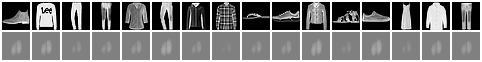

vae_outputs/gen_gaussian_baseline.png


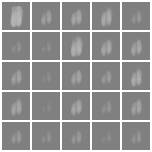

vae_outputs/gen_laplace_baseline.png


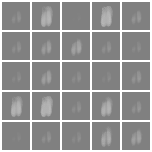

vae_outputs/recon_grid_annealed.png


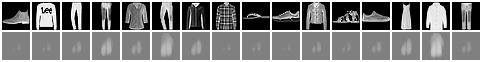

vae_outputs/gen_gaussian_annealed.png


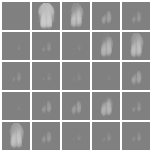

vae_outputs/gen_laplace_annealed.png


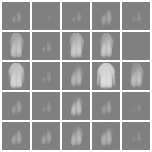

In [14]:
# Cell 15: Quick inline display of some outputs (optional)
from IPython.display import Image as IPyImage, display as ipy_display

paths_to_show = [
    "vae_outputs/recon_grid_baseline.png" if os.path.exists("vae_outputs/recon_grid_baseline.png") else "",
    "vae_outputs/gen_gaussian_baseline.png",
    "vae_outputs/gen_laplace_baseline.png",
    "vae_outputs/recon_grid_annealed.png",
    "vae_outputs/gen_gaussian_annealed.png",
    "vae_outputs/gen_laplace_annealed.png",
]

for p in paths_to_show:
    if p and os.path.exists(p):
        print(p)
        ipy_display(IPyImage(filename=p))
